In [1]:
import gensim
import fasttext.util #pip install fasttext
import pandas as pd
import numpy as np
import fasttext

C:\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### read the mordality norms datasets downloaded from : https://github.com/pablobernabeu/Modality-exclusivity-norms-747-Dutch-English-replication
There are 3 seperate files corresponding to verbs, nouns and adjcetives.

These files contain words and their corresponding perceptual strength(Auditory, Visual, Haptic) collected by asking many participants. We will consider these files as reference files and will use them to compare to compare the efficacy of our proposed method. Details can be found in [Bodo Winter, 2016, Taste and smell words form an affectively loaded and emotionally flexible part of the English lexicon]

We will use word embedding based approach to calculate the sensory scores. Two set of pre-trained embeddings have been used
* Fasttext https://fasttext.cc/docs/en/crawl-vectors.html






In [70]:

form = 'adj'

if form == 'verb':
    data= pd.read_csv('all.csv',encoding = "ISO-8859-1")
    data = data.loc[data['wordcat'].isin( ['verb', 'adv']), :] # there are hardly 4 verbs, this is uselss
elif form == 'adj':
    data = pd.read_csv('all.csv',encoding = "ISO-8859-1")
    data = data.loc[data['wordcat'].isin( ['adj']), :]
elif form == 'noun':
    data = pd.read_csv('all.csv',encoding = "ISO-8859-1")
    data = data.loc[data['wordcat'].isin( ['noun']), :]
elif form == 'all':
    data= pd.read_csv('all.csv',encoding = "ISO-8859-1")

print(data.shape)
words=data['word'].values.tolist()# words for which perceptual strength will be calculated

data = data[['word','Exclusivity', 'Auditory','Haptic', 'Visual','main']]
data = data.set_index('word', drop = True)
data.rename( columns= {'Visual':'VisualStrengthMean', 
              'Haptic':'HapticStrengthMean', 
              'Auditory':'AuditoryStrengthMean',
             'word': 'Word', 'main': 'DominantModality', 
                      'Exclusivity': 'ModalityExclusivity'}, inplace=True)

data.head()

(335, 66)


,ModalityExclusivity,AuditoryStrengthMean,HapticStrengthMean,VisualStrengthMean,DominantModality
word,,,,,
aards,0.143,1.333,1.333,2.000,Visual
absorberend,0.268,1.333,1.000,2.222,Visual
amber,0.419,0.857,0.857,2.714,Visual
barstend,0.108,2.444,2.000,2.778,Visual
behaard,0.442,0.600,3.600,4.400,Visual


## seed words which will be mapped to different modalities

The words were selected after consulation with google translate and Solvi

### verbs
* Visual -> ['zien'] ,'bekijken'
* Auditory -> ['horen'] ,'luisteren'
* Haptic -> ['voelen', 'tintje'] feel, touch
* Olfactory -> ['ruiken']
* Gustatory ->['proeven']


see, hear, touch, taste, smell

In [71]:


percept_seed2percept_cat = {'Visual':['zien'], 'Auditory': ['horen'], 
                           'Haptic': [  'voelen']} # , 'Gustatory': ['proeven'], 'Olfactory': ['ruiken']


mapwords={}
for k,vlist in percept_seed2percept_cat.items():
    for v in vlist:
        mapwords[v] = k

perceptual_seedwords = list(mapwords.keys())

mapwords, perceptual_seedwords

({'horen': 'Auditory', 'voelen': 'Haptic', 'zien': 'Visual'},
 ['horen', 'zien', 'voelen'])

In [4]:
# to calculate cosine similarity between 2 vectors
def similarity(v1, v2):
    n1 = np.linalg.norm(v1)
    n2 = np.linalg.norm(v2)
    return np.dot(v1, v2) / n1 / n2

## read pre-trained models 
### fasttext

In [5]:
#model = fasttext.train_supervised(input="cooking.train")
#fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.nl.300.bin')


### calculate cosine similarity between perceptual seed words and words.
sim_df_ft dataframe

In [72]:
add_vectors=False
if add_vectors:
    sim_df_ft = pd.DataFrame(index= words, dtype= 'float')
    for word in words:
        v1 = ft.get_word_vector(word)
        v2 = np.zeros(v1.shape)
        for perceptlist in percept_seed2percept_cat.values():
            for percept in perceptlist:
                v2+=ft.get_word_vector(percept)
            v2= np.divide(v2, len(perceptlist))
            sim_df_ft.loc[word, percept] = similarity(v1, v2) 
                

else:
    sim_df_ft = pd.DataFrame(index= words, columns = perceptual_seedwords, dtype= 'float')
    for word in words:
        for percept in perceptual_seedwords:
            #print(word)
            v1 = ft.get_word_vector(word)
            v2 = ft.get_word_vector(percept)
            sim_df_ft.loc[word, percept] = similarity(v1, v2)
sim_df_ft       

,horen,zien,voelen
aards,0.124068,0.159146,0.240649
absorberend,0.087617,0.100488,0.166679
amber,0.055546,0.028410,0.077273
barstend,0.234403,0.270847,0.222255
behaard,0.212647,0.211722,0.269289
beige,0.107931,0.110137,0.066760
beschimmeld,0.198028,0.218907,0.206925
betoverend,0.216541,0.283903,0.245820
bevriezend,0.207309,0.317609,0.223841
bewolkt,0.167089,0.264573,0.160796


In [73]:
sim_df_ft.corr(), data[['VisualStrengthMean', 'HapticStrengthMean', 'AuditoryStrengthMean']].corr()

(           horen      zien    voelen
 horen   1.000000  0.531755  0.524202
 zien    0.531755  1.000000  0.492935
 voelen  0.524202  0.492935  1.000000,
                       VisualStrengthMean  HapticStrengthMean  \
 VisualStrengthMean              1.000000            0.193152   
 HapticStrengthMean              0.193152            1.000000   
 AuditoryStrengthMean           -0.512545           -0.228115   
 
                       AuditoryStrengthMean  
 VisualStrengthMean               -0.512545  
 HapticStrengthMean               -0.228115  
 AuditoryStrengthMean              1.000000  )

In [61]:
def prepare_data(sim_df, data, mapwords):
    
    columns = ['VisualStrengthMean', 'HapticStrengthMean', 'AuditoryStrengthMean']
    
    sim_df = pd.concat([sim_df, pd.DataFrame(columns = columns)], sort=False)
    
    sim_df[columns] = data[columns].apply(pd.to_numeric).values
    
    
    return sim_df 


def add_dominantmod(sim_df, data,perceptual_seedwords):
           
    sim_df['DM_word2vec'] = sim_df[perceptual_seedwords].idxmax(axis=1).apply(lambda x: mapwords[x])
    print(sim_df.groupby("DM_word2vec").idxmax())

    print(sim_df.groupby("DM_word2vec").mean())
    if 'DominantModality' in data.columns:
        print('Dominant Modality exists in reference data \n ')
    else:
        data['DominantModality'] = data[['VisualStrengthMean', 'HapticStrengthMean', 'AuditoryStrengthMean']].idxmax(axis=1).apply(lambda x: x.replace('StrengthMean', ''))
        print('Calculated dominant modality in reference data and added as a new column to data' )
    
    #sim_df['DominantModality'] = data['DominantModality'].values
    print('Dominant modality count as per word2vec\n', sim_df['DM_word2vec'].value_counts())
    print('Dominant modailty count as per reference data \n ', data['DominantModality'].value_counts())
    return sim_df, data
    
    
def normdata(df,data, perceptual_seedwords, preprocess):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
    
    columns_ref = ['VisualStrengthMean', 'HapticStrengthMean', 'AuditoryStrengthMean']
   
    
    #
    if preprocess ==1:
        data[columns_ref] = normalize(data[columns_ref].values, norm='l2')
        df[perceptual_seedwords]= normalize(df[perceptual_seedwords], norm='l2')
    elif preprocess == 2:
        data[columns_ref]  = StandardScaler().fit_transform(data[columns_ref].values)
        df[perceptual_seedwords]= StandardScaler().fit_transform(df[perceptual_seedwords])
    elif preprocess == None:
        df = df
        data= data
        
    #temp1= normalize(temp, norm='l2')
    
    return df, data

In [68]:
preprocess= None
#sim_df_ft = prepare_data(sim_df_ft,data, mapwords)
temp_df, temp_data = normdata(sim_df_ft,data, perceptual_seedwords, preprocess )
#temp=sim_df_ft
sim_df_ft_final, data_final = add_dominantmod(temp_df, temp_data,perceptual_seedwords)

sim_df_ft_final.isnull().sum()

              horen    voelen    zien
DM_word2vec                          
Auditory       luid  hoorbaar    stil
Haptic         blij    gevoel    blij
Visual       vinden   blijven  vinden
                horen      zien    voelen
DM_word2vec                              
Auditory     0.262492  0.194756  0.188020
Haptic       0.175592  0.190072  0.248866
Visual       0.207566  0.267120  0.200864
Dominant Modality exists in reference data 
 
Dominant modality count as per word2vec
 Visual      348
Haptic      232
Auditory    167
Name: DM_word2vec, dtype: int64
Dominant modailty count as per reference data 
  Visual      545
Auditory    112
Haptic       90
Name: DominantModality, dtype: int64


horen          0
zien           0
voelen         0
DM_word2vec    0
dtype: int64

In [63]:
data_final

,ModalityExclusivity,AuditoryStrengthMean,HapticStrengthMean,VisualStrengthMean,DominantModality
word,,,,,
aankondiging,0.481,4.286,0.714,2.429,Auditory
aantekening,0.222,1.571,2.857,3.286,Visual
aanvraag,0.319,2.000,0.778,2.444,Visual
academie,0.359,2.333,1.111,3.667,Visual
achtergrond,0.510,0.667,1.444,3.556,Visual
administratie,0.389,1.889,0.889,3.222,Visual
afbeelding,0.578,0.889,1.222,5.000,Visual
afdeling,0.571,1.333,0.333,3.000,Visual
afsluiting,0.354,0.889,1.667,2.778,Visual


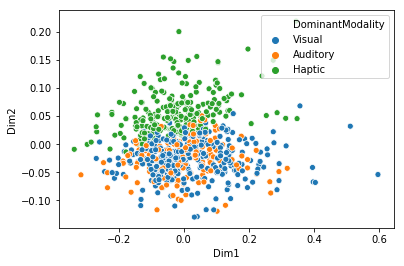

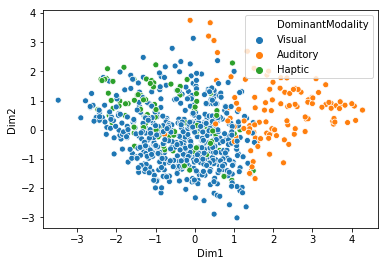

In [69]:
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import seaborn as sns
#from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
#plotvar = region2spiceingre_df_combined.T




def myplot(plotvar, color_label):
    n_components=3
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(plotvar)
    
    plot_df = pd.DataFrame(principalComponents[:,[0,1]], columns=['Dim1', 'Dim2'])
    plot_df['DominantModality'] = color_label.values
    sns.scatterplot(x='Dim1', y='Dim2', data = plot_df, hue= 'DominantModality', 
                    hue_order =['Visual', 'Auditory',  'Haptic'])
    
      

plotvar = sim_df_ft_final[perceptual_seedwords]
color_label = sim_df_ft_final['DM_word2vec']
myplot(plotvar, color_label)
plt.show()

plotvar = data_final[['VisualStrengthMean', 'HapticStrengthMean', 'AuditoryStrengthMean']]
color_label = data_final['DominantModality']
myplot(plotvar, color_label)
plt.show()


### Modality exclusivity

In [24]:
def cal_modalityExclusivity(df):
    exc = (df.max() -df.min())/df.sum()
    return exc
    
    
sim_df_ft_final['ModalityExclusivity_word2vec'] = sim_df_ft_final[perceptual_seedwords].apply(lambda x:cal_modalityExclusivity(x), axis=1)
sim_df_ft_final


,horen,zien,voelen,DM_word2vec,ModalityExclusivity_word2vec
aankondiging,1.639556,1.333751,-0.568834,Auditory,0.918451
aantekening,0.537669,-0.066522,-0.763908,Auditory,-4.445863
aanvraag,0.871448,-0.063273,-1.120955,Auditory,-6.369971
academie,-1.373758,-0.747131,-0.991611,Visual,-0.201326
achtergrond,1.582878,1.862218,-0.007817,Visual,0.544045
administratie,-0.965629,-0.916266,-1.126026,Visual,-0.069736
afbeelding,-0.000318,2.006745,-1.051681,Visual,3.203392
afdeling,-0.090161,-1.196703,-0.838328,Auditory,-0.520679
afsluiting,0.308773,-0.409624,-0.898379,Auditory,-1.208081
afstand,0.252089,0.776592,0.319746,Visual,0.388974


### calculate performance measures. Compare the scores generated by our proposed method with reference scores

In [39]:

def calc_perf(ytest, ypred):
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report#, balanced_accuracy_score, roc_auc_score
    
    #print('balanced accuracy score\n', balanced_accuracy_score( ytest, ypred))
    print('confusion matrix\n', confusion_matrix( ytest, ypred,labels = ['Visual', 'Auditory','Haptic', ]))
    print('classification report \n',classification_report(ytest, ypred))
    #fpr, tpr = roc_curve(sim_df['DominantModality'], sim_df['DM_word2vec'])
    #plt.plot(fpr, tpr)
    from sklearn.preprocessing import label_binarize
    label_binarize([1, 6], classes=[1, 2, 4, 6])
    y_test_binary = label_binarize(ytest.values, classes =['Visual', 'Auditory','Haptic'] )
                                                                                  
    y_prob_binary = label_binarize(ypred.values, classes =['Visual', 'Auditory','Haptic'] )
    
    '''                                                                             
    macro_roc_auc_ovo = roc_auc_score(y_test_binary, y_prob_binary, multi_class="ovo",
                                  average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_test_binary, y_prob_binary, multi_class="ovo",
                                         average="weighted")
    macro_roc_auc_ovr = roc_auc_score(y_test_binary, y_prob_binary, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test_binary, y_prob_binary, multi_class="ovr",
                                         average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    
    '''
ytest= data_final['DominantModality']
ypred = sim_df_ft_final['DM_word2vec']
calc_perf(ytest, ypred)

confusion matrix
 [[166  65  79]
 [ 12  28   8]
 [ 15   2  28]]
classification report 
              precision    recall  f1-score   support

   Auditory       0.29      0.58      0.39        48
     Haptic       0.24      0.62      0.35        45
     Visual       0.86      0.54      0.66       310

avg / total       0.72      0.55      0.59       403

